# Part II: the mutli-layer perceptron

This report describes the implementation of a multi-layer perceptron using numpy. All src can be found in the Part_2. Run All to see all results.

Alternatively, you can run the python script in your terminal.

```bash

cd Part_2
python train_mlp_numpy.py --dnn_hidden_units 20 --learning_rate 0.01 --max_steps 15 --eval_freq 1

```


First, implement the MLP architecture by completing the files mlp numpy.py and modules.py.

Although our MLP isn't going to be extremly deep, I still use He initialization for the weights in Linear layers, which can prevent gradient exploding or vanishing to some extent.
```python
self.params = {
            'weight': np.random.randn(in_features, out_features) / np.sqrt(2. / in_features),
            'bias': np.zeros((1, out_features))
        }
```

The MLP architecture is a feedforward neural network, as scrtached below. I add the update_params function to update the parameters of the network during training.
```python
class MLP(object):
    def __init__(self, n_inputs, n_hidden, n_classes):
        self.layers = []
        for hidden in n_hidden:
            self.layers.append(Linear(n_inputs, hidden))
            self.layers.append(ReLU())
            n_inputs = hidden
        self.layers.append(Linear(n_inputs, n_classes))
        self.layers.append(SoftMax())
    def forward(self, x):
        out = x  
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def backward(self, dout):
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

    def update_params(self, learning_rate):
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.params['weight'] -= learning_rate * layer.grads['weight']
                layer.params['bias'] -= learning_rate * layer.grads['bias']
```

Then, Implement training and testing script in train mlp numpy.py.

The accuracy function imported from Part_2 module is implemented using sklearn.metrics.accuracy_score.

In [9]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from train_mlp_numpy import accuracy
from mlp_numpy import MLP 
from modules import CrossEntropy 

In [10]:
from matplotlib import pyplot as plt
def generate_data():
    X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)

    plt.figure(figsize=(10, 8))
    plt.scatter(X[y==0][:, 0], X[y==0][:, 1], c='red', marker='o', label='Class 0', alpha=0.7)
    plt.scatter(X[y==1][:, 0], X[y==1][:, 1], c='blue', marker='x', label='Class 1', alpha=0.7)
    plt.show()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    encoder = OneHotEncoder(sparse_output=False)
    y_train_onehot = encoder.fit_transform(y_train)
    y_test_onehot = encoder.transform(y_test)
    return X_train, X_test, y_train_onehot, y_test_onehot

Use sklearn to generate and preprocess (split and onehotencode) data, and visualize it by the way.

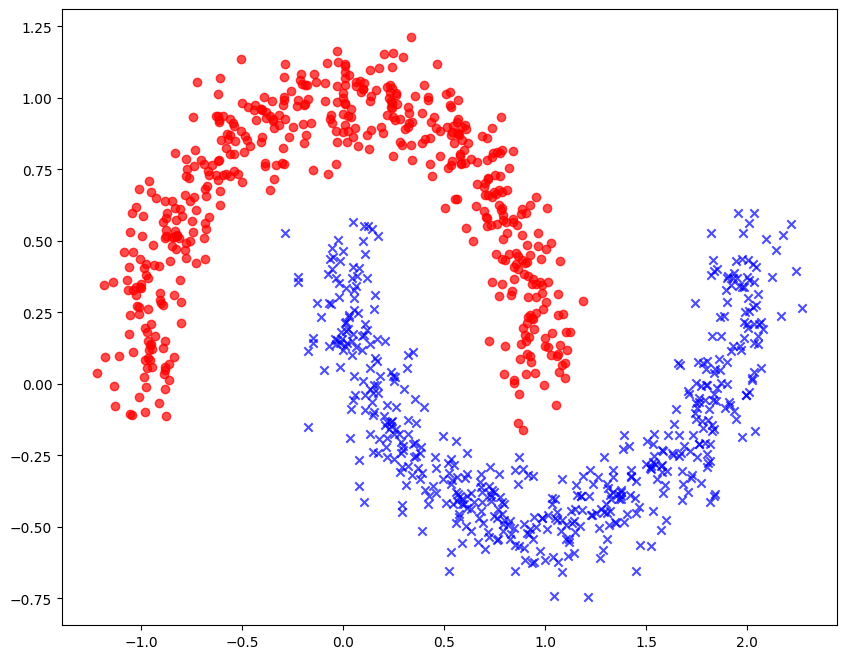

(800, 2) (200, 2) (800, 2) (200, 2)


In [11]:
X_train, X_test, y_train, y_test = generate_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

I implement a DataLoader class to load data in batches.

In [12]:
import numpy as np

class DataLoader:
    def __init__(self, X, y, batch_size=32, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = X.shape[0]
        self.indices = np.arange(self.num_samples)

    def __iter__(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.current = 0
        return self

    def __next__(self):
        if self.current >= self.num_samples:
            raise StopIteration
        start = self.current
        end = min(self.current + self.batch_size, self.num_samples)
        batch_idx = self.indices[start:end]
        self.current = end
        return self.X[batch_idx], self.y[batch_idx]

    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))

Then let's first test our MLP with default parameters, and start to train it on training data.

In [13]:
mlp = MLP(n_inputs=2, n_hidden=[20], n_classes=2)
criteria = CrossEntropy()
test_output = mlp.forward(X_test)
test_loss = criteria.forward(test_output, y_test)
test_accuracy = accuracy(test_output, y_test)
print(f" Loss: {test_loss:4f}, Accuracy: {test_accuracy:4f}")

 Loss: 3.055823, Accuracy: 58.000000


/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_2/modules.py:28: RuntimeWarning: divide by zero encountered in matmul
  return x @ self.params['weight'] + self.params['bias']
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_2/modules.py:28: RuntimeWarning: overflow encountered in matmul
  return x @ self.params['weight'] + self.params['bias']
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_2/modules.py:28: RuntimeWarning: invalid value encountered in matmul
  return x @ self.params['weight'] + self.params['bias']


If you run this cell a few times, you'll see that the test acc is about 50% (more or less), which is not better than randomly guessing since we only have 2 classes. But this is due to randomness in initialization, not that the model has already learned something.

Let's start trainnig and visualize the loss curve for both training and test dataset and accuracy on test dataset.

In [14]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train(dnn_hidden_units, learning_rate, max_epochs, eval_freq):
    np.random.seed(42) 

    trainloader = DataLoader(X_train, y_train)
    for epoch in range(max_epochs):
        epoch_train_loss = 0
        epoch_train_accuracy = 0
        batch_count = 0
        for _, (X_batch, y_batch) in enumerate(trainloader):
            output = mlp.forward(X_batch)
            loss = criteria.forward(output, y_batch)
            mlp.backward(criteria.backward())
            mlp.update_params(learning_rate)
            epoch_train_loss += loss
            batch_count += 1
            train_accuracy = accuracy(output, y_batch)
            epoch_train_accuracy += train_accuracy
        avg_train_loss = epoch_train_loss / batch_count
        avg_train_accuracy = epoch_train_accuracy / batch_count
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)
        print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}")
        if epoch % eval_freq == 0 or epoch == max_epochs - 1:
            test_output = mlp.forward(X_test)
            test_loss = criteria.forward(test_output, y_test)
            test_accuracy = accuracy(test_output, y_test)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)
            print(f"Epoch: {epoch+1}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}")
    print("Training complete!")

In [15]:
dnn_hidden_units = [20]
learning_rate = 1e-2
max_epochs = 15
eval_freq = 1

train(dnn_hidden_units, learning_rate, max_epochs, eval_freq)

Epoch: 1, Train Loss: 2.2430
Epoch: 1, Test Loss: 1.4003, Test Acc: 67.50
Epoch: 2, Train Loss: 1.0774
Epoch: 2, Test Loss: 0.8960, Test Acc: 71.00
Epoch: 3, Train Loss: 0.7738
Epoch: 3, Test Loss: 0.7264, Test Acc: 74.00
Epoch: 4, Train Loss: 0.6749
Epoch: 4, Test Loss: 0.6476, Test Acc: 78.00
Epoch: 5, Train Loss: 0.6193
Epoch: 5, Test Loss: 0.5935, Test Acc: 79.00
Epoch: 6, Train Loss: 0.5730
Epoch: 6, Test Loss: 0.5484, Test Acc: 80.50
Epoch: 7, Train Loss: 0.5340
Epoch: 7, Test Loss: 0.5083, Test Acc: 82.00
Epoch: 8, Train Loss: 0.4972
Epoch: 8, Test Loss: 0.4722, Test Acc: 82.50
Epoch: 9, Train Loss: 0.4631
Epoch: 9, Test Loss: 0.4392, Test Acc: 82.50
Epoch: 10, Train Loss: 0.4321
Epoch: 10, Test Loss: 0.4091, Test Acc: 83.50
Epoch: 11, Train Loss: 0.4038
Epoch: 11, Test Loss: 0.3817, Test Acc: 84.00
Epoch: 12, Train Loss: 0.3780
Epoch: 12, Test Loss: 0.3571, Test Acc: 84.00
Epoch: 13, Train Loss: 0.3546
Epoch: 13, Test Loss: 0.3349, Test Acc: 84.00
Epoch: 14, Train Loss: 0.3325


/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_2/modules.py:38: RuntimeWarning: divide by zero encountered in matmul
  dx = dout @ self.params['weight'].T
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_2/modules.py:38: RuntimeWarning: overflow encountered in matmul
  dx = dout @ self.params['weight'].T
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_2/modules.py:38: RuntimeWarning: invalid value encountered in matmul
  dx = dout @ self.params['weight'].T
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_2/modules.py:38: RuntimeWarning: divide by zero encountered in matmul
  dx = dout @ self.params['weight'].T
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_2/modules.py:38: RuntimeWarning: overflow encountered in matmul
  dx = dout @ self.params['weight'].T
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_2/modules.py:38: RuntimeWarning: invalid value encountered in matmul
  dx = dout @ self.params['weight'].T
/Users/dove/

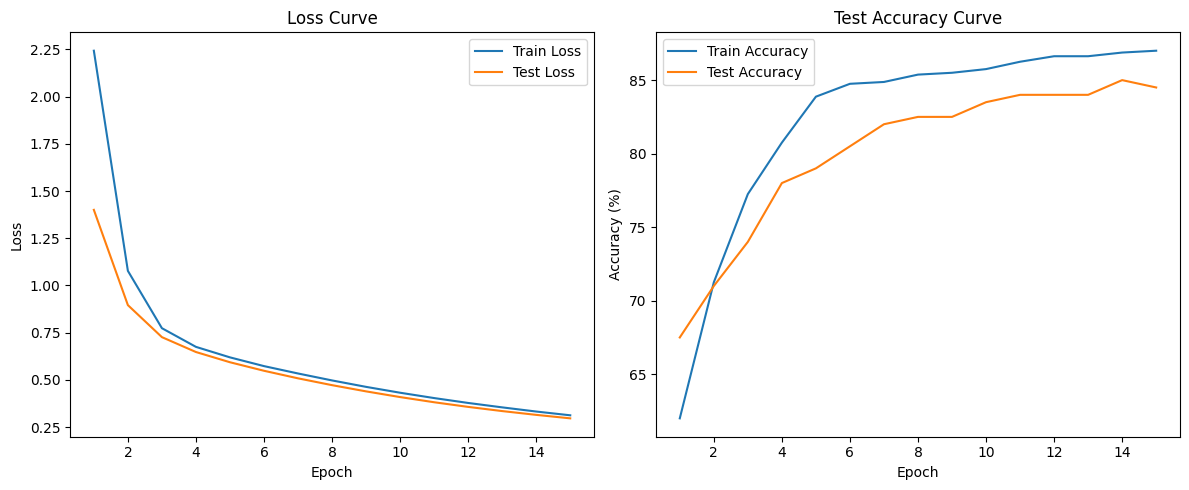

In [16]:

epochs = range(1, max_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, [test_losses[i] if i < len(test_losses) else None for i in range(max_epochs)], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, [test_accuracies[i] if i < len(test_accuracies) else None for i in range(max_epochs)], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Test Accuracy Curve')

plt.tight_layout()
plt.show()

## Result Analysis

The figure shows that at the beginning of training, train_loss is high and train_acc is low (80% this time, thanks to good random seed). As the training progresses, train_loss decreases and train_acc increases. Our MLP gradually learns to classify the training data.

Note that sometimes the test_loss is even lower than the train_loss. This can happen due to random data splits, or the test set being easier than the training set by chance. As training progresses, train_loss usually becomes lower than test_loss. This does not indicate overfitting, but rather reflects the randomness in data and training process.